In [16]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [17]:
df = pd.read_csv('./../error_dfs/error_2019_ARIMA.csv', converters={'ags2': str, 'ags5': str} )

In [18]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [19]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2019-01-31,8.2,7.801405,0.398595,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2019-02-28,7.8,8.052910,0.252910,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2019-03-31,7.8,7.763520,0.036480,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2019-04-30,7.6,7.634104,0.034104,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2019-05-31,7.7,7.337496,0.362504,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
4807,16077,2019-08-31,7.0,6.978600,0.021400,16,Thüringen,Altenburger Land
4808,16077,2019-09-30,6.5,6.839895,0.339895,16,Thüringen,Altenburger Land
4809,16077,2019-10-31,6.5,6.451817,0.048183,16,Thüringen,Altenburger Land
4810,16077,2019-11-30,6.3,6.556410,0.256410,16,Thüringen,Altenburger Land


In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [22]:
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2019-01-31,8.2,7.801405,4.860915,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2019-02-28,7.8,8.052910,3.242441,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2019-03-31,7.8,7.763520,0.467691,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2019-04-30,7.6,7.634104,0.448743,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2019-05-31,7.7,7.337496,4.707847,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
4807,16077,2019-08-31,7.0,6.978600,0.305708,16,Thüringen,Altenburger Land
4808,16077,2019-09-30,6.5,6.839895,5.229153,16,Thüringen,Altenburger Land
4809,16077,2019-10-31,6.5,6.451817,0.741279,16,Thüringen,Altenburger Land
4810,16077,2019-11-30,6.3,6.556410,4.069998,16,Thüringen,Altenburger Land


## Plot each variable

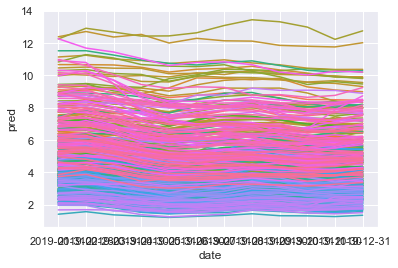

In [23]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.legend_.remove()

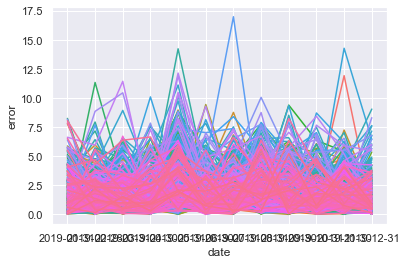

In [24]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.legend_.remove()

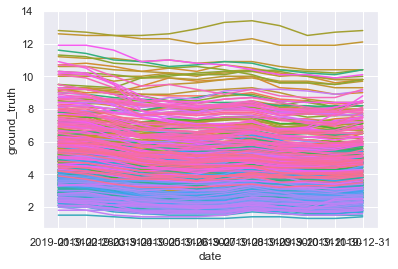

In [25]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.legend_.remove()

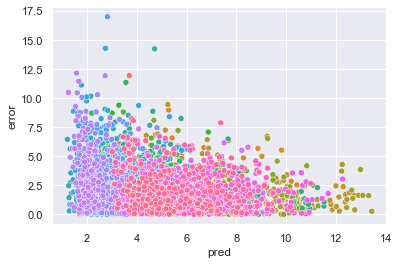

In [26]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [27]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [28]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [29]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

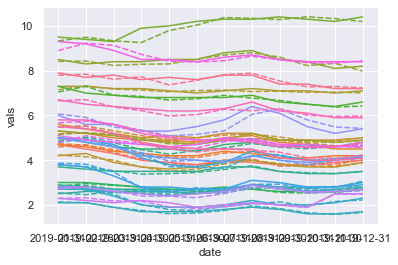

In [30]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.legend_.remove()

## Look into mean errors

In [31]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",7.958333,7.853025,2.627300
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.591667,7.579645,1.551736
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.275000,7.274474,1.303818
01004,01,Schleswig-Holstein,"Neumünster, Stadt",7.900000,7.881733,1.150352
01051,01,Schleswig-Holstein,Dithmarschen,5.500000,5.489077,1.087983
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.241667,5.257047,1.640977
16074,16,Thüringen,Saale-Holzland-Kreis,4.141667,4.142775,2.264730
16075,16,Thüringen,Saale-Orla-Kreis,4.600000,4.630328,2.034851


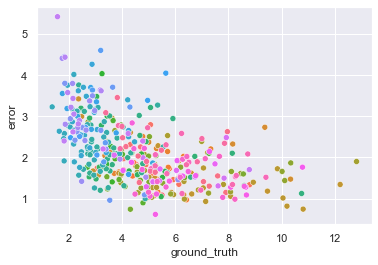

In [32]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

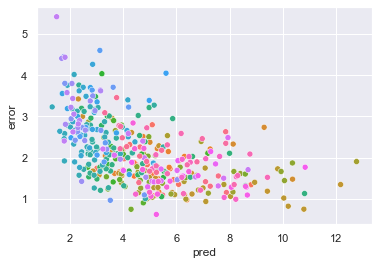

In [33]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [34]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09779,09,Freistaat Bayern,Donau-Ries,1.566667,1.515176,5.420105
09476,09,Freistaat Bayern,Kronach,3.191667,3.137184,4.602033
09575,09,Freistaat Bayern,Neustadt a.d.Aisch-Bad Windsheim,1.825000,1.784374,4.451156
09773,09,Freistaat Bayern,Dillingen a.d.Donau,1.850000,1.830330,4.436085
09677,09,Freistaat Bayern,Main-Spessart,1.741667,1.705353,4.409793
...,...,...,...,...,...,...
06532,06,Hessen,Lahn-Dill,4.783333,4.765751,0.898833
05113,05,Nordrhein-Westfalen,Essen,10.200000,10.198943,0.817881
05112,05,Nordrhein-Westfalen,Duisburg,10.808333,10.785947,0.745685


<AxesSubplot:xlabel='error', ylabel='Density'>

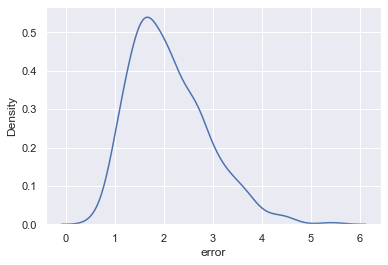

In [35]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [36]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
3318,09476,2019-07-31,3.4,2.821355,17.018968,09,Freistaat Bayern,Kronach
3082,09279,2019-11-30,2.4,2.743271,14.302963,09,Freistaat Bayern,Dingolfing-Landau
2356,08222,2019-05-31,5.5,4.715860,14.257093,08,Baden-Württemberg,Mannheim
3724,09773,2019-05-31,1.8,1.580980,12.167798,09,Freistaat Bayern,Dillingen a.d.Donau
142,01059,2019-11-30,4.2,3.698306,11.945097,01,Schleswig-Holstein,Schleswig-Flensburg
...,...,...,...,...,...,...,...,...
604,03452,2019-05-31,5.9,5.900300,0.005090,03,Niedersachsen,Aurich
661,03457,2019-02-28,5.9,5.899752,0.004197,03,Niedersachsen,Leer
764,05111,2019-09-30,6.6,6.599746,0.003855,05,Nordrhein-Westfalen,Düsseldorf
4584,16055,2019-01-31,6.3,6.300128,0.002039,16,Thüringen,Weimar


In [37]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

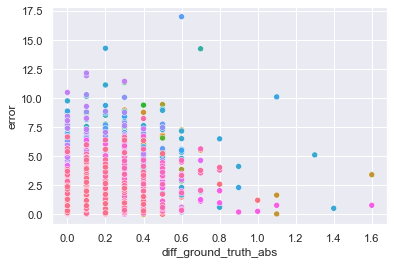

In [38]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

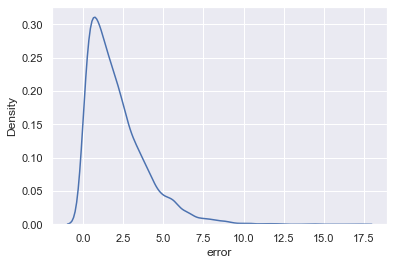

In [39]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

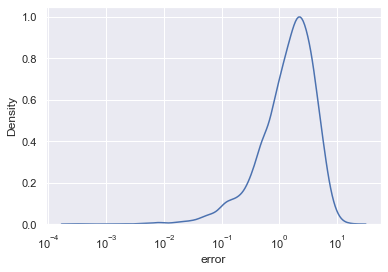

In [40]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [41]:
df_structural = pd.read_csv('./../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_/_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,2,99,99,1,1,C,1
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,1,99,99,1,0,C/D,1
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,1,5,99,1,0,C/D,1
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,2,5,99,1,0,D,1
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,2,5,99,1,0,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,2,99,99,2,0,C*,1
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,2,99,99,2,0,C*,1
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,2,99,99,2,2,C*,1
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,1,99,99,2,0,C*,1


### Merge to df with mean errors

In [42]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [43]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

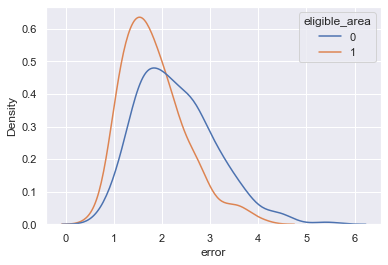

Ttest_indResult(statistic=6.211092443337916, pvalue=1.334029295774985e-09)

In [44]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

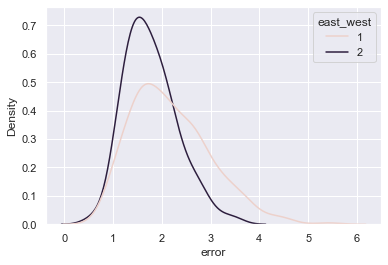

Ttest_indResult(statistic=-5.3649592497633805, pvalue=2.6403778408581305e-07)

In [45]:
compare_error_in_two_groups(df_mixed, 'east_west')

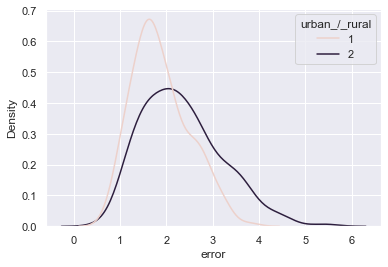

Ttest_indResult(statistic=6.089718215335898, pvalue=2.8620937586470433e-09)

In [46]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [47]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

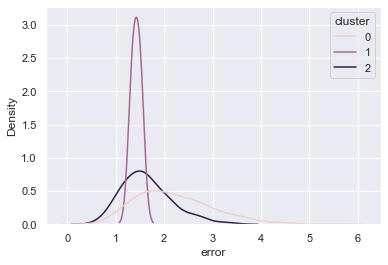

              sum_sq     df          F        PR(>F)
cluster    17.783012    1.0  31.634455  3.506067e-08
Residual  224.294102  399.0        NaN           NaN


In [48]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


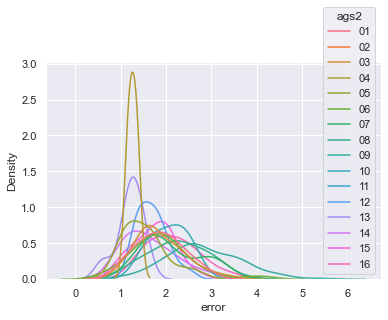

              sum_sq     df          F        PR(>F)
ags2       89.848037   15.0  15.148878  1.196771e-30
Residual  152.229076  385.0        NaN           NaN


In [49]:
compare_error_in_two_groups(df_mixed, "ags2")

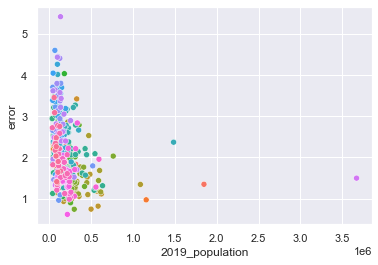

In [50]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

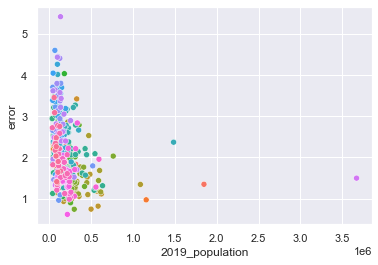

In [51]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [52]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [53]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [54]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [55]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min     1Q  Median     3Q    Max
-0.5903 -0.137 -0.0092 0.1234 0.7288


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -158.584337  2.439904e+05+1.200000e-05j  -0.0006+0.0000j  0.999482
supermarkets_population                             0.001542  8.077000e-03-8.700000e-05j   0.1910+0.0021j  0.848652
supermarkets_average_distance                       0.000068  1.169000e-03+2.024000e-03j   0.0145-0.0251j  0.976882
public_transport_availability                       0.001962  2.647000e-03+3.440000e-04j   0.7289-0.0948j  0.462726
average_distance_bus_stop                           0.000156  2.530000e-04-4.000000e-06j   0.6153+0.0108j  0.538638
average_distance_train_station                      0.000008  3.100000e-05+1.000000e-06j   0.2714-0.0095j  0.786119
average_distance_public_transport                  -0.000203  4.240000e-04+1.890000e-04

### Sequential Feature Selector

In [56]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [57]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(177,)","[-0.12179022847098797, -0.0065816181006421726,...",-0.101416,"(ags2_09,)",0.186588,0.145172,0.072586
2,"(152, 177)","[0.07967547520236562, 0.0069277360185350245, -...",0.002552,"(debtor_quota, ags2_09)",0.102508,0.079755,0.039877
3,"(69, 152, 177)","[0.24475094941437947, 0.05544558442000658, -0....",0.072494,"(Number_of_Commuters_on_place_of_residence), d...",0.155362,0.120877,0.060439
4,"(69, 147, 152, 177)","[0.25429999256187885, 0.05593309488522069, -0....",0.13621,"(Number_of_Commuters_on_place_of_residence), s...",0.124585,0.096931,0.048466
5,"(25, 69, 147, 152, 177)","[0.2573374070255895, 0.06613221895234656, -0.0...",0.146427,"(kilometers_per_person_and_day, Number_of_Comm...",0.125212,0.097419,0.04871
6,"(25, 65, 69, 147, 152, 177)","[0.2481238633150059, 0.04210342171915182, 0.02...",0.155889,"(kilometers_per_person_and_day, no_of_foreigne...",0.129065,0.100417,0.050209
7,"(8, 25, 65, 69, 147, 152, 177)","[0.29826639277978995, 0.09006294599771358, 0.1...",0.209859,"(number_of_hospital_beds, kilometers_per_perso...",0.1083,0.084261,0.042131
8,"(8, 25, 65, 69, 140, 147, 152, 177)","[0.312479133791016, 0.11735991463157391, 0.133...",0.217793,"(number_of_hospital_beds, kilometers_per_perso...",0.100186,0.077948,0.038974
9,"(8, 25, 65, 69, 90, 140, 147, 152, 177)","[0.3057726096242689, 0.11822838930660029, 0.15...",0.223001,"(number_of_hospital_beds, kilometers_per_perso...",0.095445,0.07426,0.03713
10,"(8, 25, 65, 69, 90, 102, 140, 147, 152, 177)","[0.3094416447801197, 0.11968469719898078, 0.14...",0.22455,"(number_of_hospital_beds, kilometers_per_perso...",0.098487,0.076626,0.038313


In [58]:
list(summary_table_select['feature_names'])[:5]

[('ags2_09',),
 ('debtor_quota', 'ags2_09'),
 ('Number_of_Commuters_on_place_of_residence)', 'debtor_quota', 'ags2_09'),
 ('Number_of_Commuters_on_place_of_residence)',
  'standing_water_percentage',
  'debtor_quota',
  'ags2_09'),
 ('kilometers_per_person_and_day',
  'Number_of_Commuters_on_place_of_residence)',
  'standing_water_percentage',
  'debtor_quota',
  'ags2_09')]

### Ridge

In [59]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [60]:
stats.summary(rr, X, Y, X.columns)

Residuals:
   Min      1Q  Median     3Q   Max
-0.595 -0.1426 -0.0113 0.1285 0.705


Coefficients:
                                                  Estimate                  Std. Error         t value   p value
_intercept                                        0.624731  2.480550e+05+1.200000e-05j  0.0000-0.0000j  0.999998
supermarkets_population                           0.002542  3.790000e-03+0.000000e+00j  0.6706-0.0000j  0.502860
supermarkets_average_distance                     0.000058  1.701000e-03+0.000000e+00j  0.0342-0.0000j  0.972742
public_transport_availability                     0.000094  6.800000e-04+0.000000e+00j  0.1384-0.0000j  0.889985
average_distance_bus_stop                         0.000145  2.830000e-04-0.000000e+00j  0.5144+0.0000j  0.607273
average_distance_train_station                    0.000012  3.000000e-05+0.000000e+00j  0.3819-0.0001j  0.702738
average_distance_public_transport                -0.000226  2.190000e-04-0.000000e+00j -1.0296-0.0000j  0.3038

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

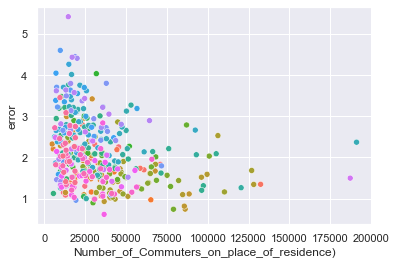

In [61]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

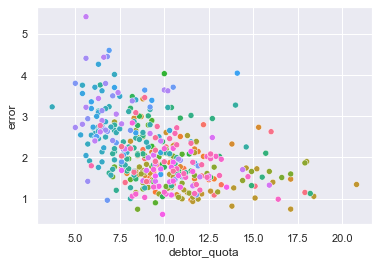

In [62]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

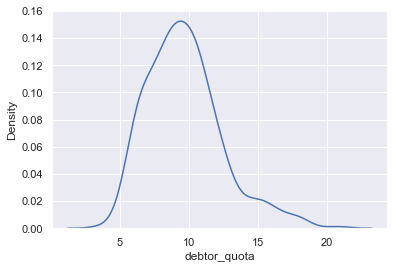

In [63]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

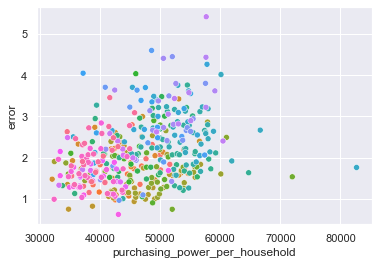

In [64]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

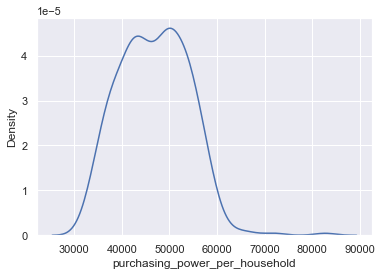

In [65]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

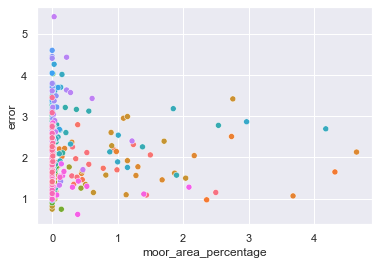

In [66]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()